<a href="https://colab.research.google.com/github/saikoneru/visualize_beam_huggingface/blob/main/visualize_beam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Download and Load NLLB-200-distilled-600M's model and tokenizer.
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M")


In [48]:
# @title Enter your input sentences, select or type the language code you want to generate the translation in and visualize the beam

source_text = 'it is really beautiful' # @param {type:"string"}
target_language = 'deu_Latn' # @param ["deu_Latn", "rus_Cyrl", "tel_Telu"] {allow-input: true}
num_beams = 5 # @param {type:"integer"}
num_return_sequences = 1 # @param {type:"integer"}
inputs = tokenizer([source_text], return_tensors="pt", padding = True)
prefix_translation = 'Sie' # @param {type:"string"}

print("Generating.....")

if prefix_translation == "":
  outputs = model.generate(
      **inputs, forced_bos_token_id=tokenizer.lang_code_to_id["deu_Latn"],do_sample=False,return_dict_in_generate=True, output_scores=True,num_beams=num_beams,num_return_sequences=num_return_sequences
  )
else:
  decoder_start_ids = {i+2: id for i, id in enumerate(tokenizer.encode(prefix_translation,add_special_tokens=False))}
  outputs = model.generate(
      **inputs, forced_bos_token_id=tokenizer.lang_code_to_id[target_language],forced_decoder_ids=decoder_start_ids,do_sample=True,return_dict_in_generate=True, output_scores=True,num_beams=num_beams,num_return_sequences=num_return_sequences
  )
print("Finished")
print("{} outputs returned by the model".format(num_return_sequences))
cnt=0
for pred_sent in tokenizer.batch_decode(outputs.sequences, skip_special_tokens=True):
  print("Sequence ID: {} -- ".format(cnt) + pred_sent)
  cnt+=1

Generating.....
Finished
1 outputs returned by the model
Sequence ID: 0 -- Sie ist wirklich wunderschön.


<ipython-input-50-947ebc691cd2>:59: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group, df_group in df.groupby(['parent'],sort=False):


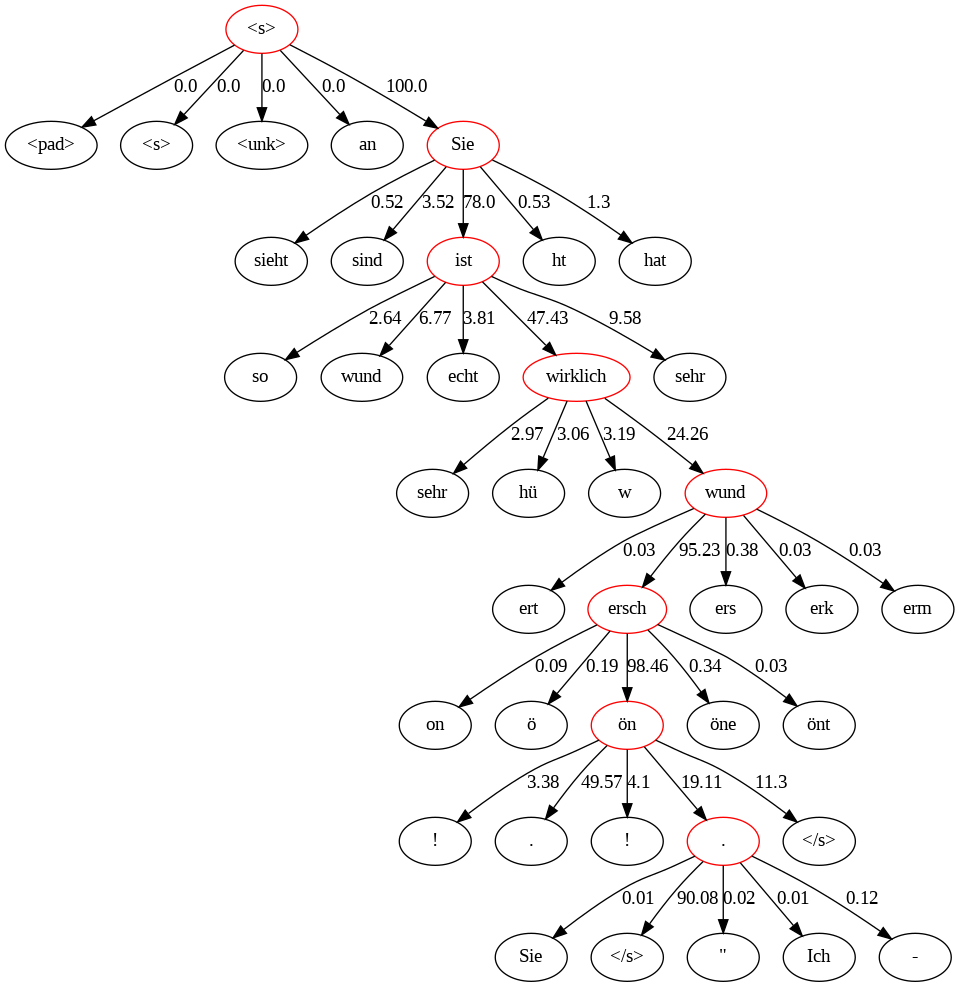

In [50]:
# @title Select number of alternative tokens you want to include in the Visualization and for which Sequence ID

import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from graphviz import Digraph
import graphviz
from IPython.display import display, Image


top_k = 5 # @param {type:"integer"}
seq_id = 0 # @param {type:"integer"}

def get_alternatives(outputs, seq_id, top_k, start_prefix_tokens):
    visualize_seq = outputs.sequences[seq_id][outputs.sequences[seq_id]!=tokenizer.pad_token_id]
    visualize_seq = visualize_seq.squeeze()[start_prefix_tokens:]

    parents = []
    childs = []
    edges = []

    curr_parent = tokenizer.bos_token_id


    for pos in range(visualize_seq.shape[0]):
      logits = outputs.scores[pos + 1][outputs.beam_indices[seq_id][pos + 1]]
      top_values, top_indices = torch.topk(logits, k=top_k)

      parents.append(curr_parent)
      childs.append(visualize_seq[pos])
      edges.append(np.exp(logits[visualize_seq[pos]]))

      for top_tok in top_indices[1:]:
        if top_tok != visualize_seq[pos]:
          parents.append(curr_parent)
          childs.append(top_tok)
          edges.append(np.exp(logits[top_tok]))
      curr_parent = visualize_seq[pos]
    return parents, childs, edges

def visualize_beam(parents,childs, edges):
    # Example DataFrame with hierarchical data
    data = {
        'parent': tokenizer.batch_decode(parents),
        'child': tokenizer.batch_decode(childs),
        'label': [round(x.numpy()*100,2) for x in edges]  # Adding edge labels
    }
    df = pd.DataFrame(data)

    # Create a directed graph using graphviz
    dot = Digraph(comment='Hierarchical Tree', format='png')
    dot.attr(rankdir='TB')  # Set the direction to top-to-bottom
    dot.attr('graph', center='true')  # Center the graph

    child_parent_idx = {}
    init_parent = df.iloc[0]['parent']
    pl=0
    cl=-1

    for group, df_group in df.groupby(['parent'],sort=False):
        parent_label = group
        if parent_label!=init_parent:
          pl = child_parent_idx[parent_label]
          child_parent_idx = {}

        for _, row in df_group.sample(frac=1).iterrows():

          child_label = row['child']
          dot.node(str(pl), graphviz.nohtml(parent_label),color="red")
          dot.node(str(cl), graphviz.nohtml(child_label))
          dot.edge(str(pl), str(cl), label=str(row['label']))
          child_parent_idx[child_label] = cl
          cl-=1

    # Save the graph as a PNG file
    dot.render(filename="visualize_beam", cleanup=True, format="png")
    display(Image(filename="visualize_beam.png"))

parents, childs, edges = get_alternatives(outputs=outputs, seq_id=seq_id, top_k=top_k, start_prefix_tokens=2)
visualize_beam(parents,childs,edges)

In [52]:
# @title Compute only Transition Probabilities without alternatives

import numpy as np
transition_scores = model.compute_transition_scores(
    outputs.sequences, outputs.scores, outputs.beam_indices, normalize_logits=False
)
generated_tokens = outputs.sequences[:, 1:]
for tok, score in zip(generated_tokens[seq_id], transition_scores[seq_id]):
    # | token | token string | logits | probability
    print(f"| {tok:5d} | {tokenizer.decode(tok):8s} | {score.numpy():.3f} | {np.exp(score.numpy()):.2%}")

| 256042 | deu_Latn | 0.000 | 100.00%
|  4856 | Sie      | 0.000 | 100.00%
|  1876 | ist      | -0.248 | 78.00%
| 59209 | wirklich | -0.746 | 47.43%
| 240636 | wund     | -1.416 | 24.26%
| 97905 | ersch    | -0.049 | 95.23%
|  3115 | ön       | -0.016 | 98.46%
| 248075 | .        | -0.702 | 49.57%
|     2 | </s>     | -0.104 | 90.08%
